## PRIZM Analysis Pipeline

In [4]:
import importlib
import sys
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import pocomc as pc
import corner
import scipy.stats as stats
from data_prep import DataPrep
from rfi_flagging import RFI_flagging
import helper_functions as hf
from gsm_data import GSMData, get_desired_frequencies

In [149]:
_ = importlib.reload(sys.modules['gsm_data'])
_ = importlib.reload(sys.modules['helper_functions'])
import helper_functions as hf
from gsm_data import GSMData, get_desired_frequencies

#### Load Data & GSM

If uploading data from saved NumPy files:

In [2]:
import numpy as np

In [6]:
np.diff(np.sort([1634829213, 1634840045,  1634850881,  1634861719,  1634872537,  1634883370, 1634894207,
1634832827, 1634843646, 1634854495,  1634865325, 1634876145, 1634886983, 1634897816,
1634836439,  1634847261,  1634858107,  1634868928 , 1634879760,  1634890597]))

array([3614, 3612, 3606, 3601, 3615, 3620, 3614, 3612, 3612, 3606, 3603,
       3609, 3608, 3615, 3610, 3613, 3614, 3610, 3609])

In [ ]:
instrument = '100MHz'
year = '2021'

channel = 'NS'

# times
path2file = f'../Data/{year}/{instrument[:-3]}/{channel}/'
file_ending = f'_{year}_{instrument[:-3]}{channel}.npy'

with open(path2file + 'lst' + file_ending, 'rb') as f:
    lst = np.load(f)
with open(path2file + 'systime' + file_ending, 'rb') as f:
    systime = np.load(f)

    
# channel = 'NS'

# # rfi flagged data & freq
# with open(f'RFI_flagged/rfi_flagged_{instrument[:-3]}{channel}.npz', 'rb') as f:
#     data_file = np.load(f)
#     data = data_file['data']
#     freq = data_file['freq']

# # gsm
# Tgsm = np.load(f'GSM_averages/{instrument}_{channel}_GSM_average_2minbins_horizon_0align.npy')
# TgsmH = np.load(f'GSM_averages/{instrument}_{channel}_Haslam255_average_2minbins_horizon_0align.npy')

In [ ]:
lst.shape

#### Binning

In [373]:
binsize_f = 1
binsize_t = 2
flow = 50
fhigh = 136
data_binned, freq_1mhz, lst_2min, bin_inds_f, bin_inds_t = hf.binning(data, freq, lst, binsize_f, binsize_t, flow, fhigh)

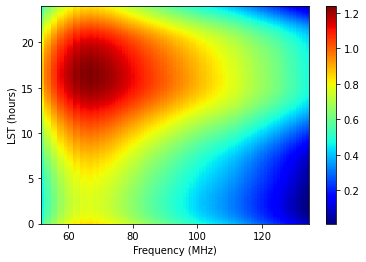

In [6]:
plt.figure()
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.pcolormesh(freq_1mhz, lst_2min, 
               np.log10(data_binned), cmap='jet', shading='nearest')
plt.colorbar()
plt.show()

# GSM calibration

In [206]:
gsm_flow = 30

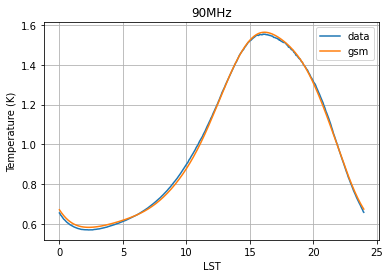

In [256]:
f = 90
offset = 10

fig = plt.figure()
ax = fig.subplots(1,1)
ax.grid()
ax.set_title(f'{f}MHz')
ax.set_ylabel('Temperature (K)')
ax.set_xlabel('LST')
ax.plot(lst_2min, data_binned[:, (f - flow)] / np.mean(data_binned[:, (f - flow)]), \
           label='data')
ax.plot(lst_2min, Tgsm[(np.arange(720)+offset)%720, (f - gsm_flow)//2] / np.mean(Tgsm[(np.arange(720)+offset)%720, (f - gsm_flow)//2]), \
           label='gsm')
ax.legend()

In [309]:
Tcmb = 2.725
offset = 10
Tgsm_c = Tgsm[(np.arange(720)+offset)%720, (flow-gsm_flow)//2:(fhigh-gsm_flow)//2 + 1] + Tcmb
krat = Tgsm_c / data_binned[:, ::2]
x = freq_1mhz[::2]

### SVD

In [310]:
# bone = np.ones((krat.shape[0],krat.shape[1]))
n = krat.shape[0]
r = np.linalg.matrix_rank(krat)
U, σ, VH = np.linalg.svd(krat, full_matrices=True)
# V = VH.T

# sigma_inv = np.vstack([np.diag(1/σ), np.zeros((n-r,r))])
sigma = np.vstack([np.diag(σ), np.zeros((n-r,r))])
# V1=V[:,0:r] 
# Sr=sigma_inv[0:r,0:r]
# U1=U[:,0:r]

# xk = V1 @ Sr @ U1.T @ bone

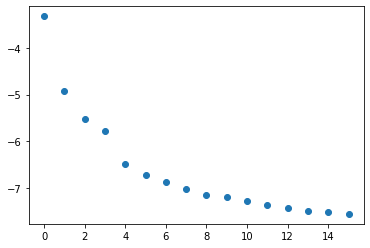

In [311]:
plt.scatter(range(16),np.log10(σ[0:16]))

In [312]:
#get first 5 modes of K
mode1= np.reshape(U[:,0],(krat.shape[0],1))*sigma[0,0]* np.reshape(VH[0,:], (1,krat.shape[1]))
mode2= np.reshape(U[:,1],(krat.shape[0],1))*sigma[1,1]* np.reshape(VH[1,:], (1,krat.shape[1]))
mode3= np.reshape(U[:,2],(krat.shape[0],1))*sigma[2,2]* np.reshape(VH[2,:], (1,krat.shape[1]))
mode4= np.reshape(U[:,3],(krat.shape[0],1))*sigma[3,3]* np.reshape(VH[3,:], (1,krat.shape[1]))
mode5= np.reshape(U[:,4],(krat.shape[0],1))*sigma[4,4]* np.reshape(VH[4,:], (1,krat.shape[1]))

Text(0, 0.5, 'Mode 1 of Calibration Parameter K')

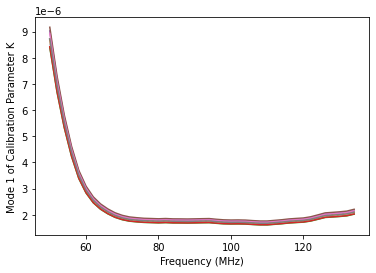

In [313]:
plt.plot(x, np.mean(mode1, axis=0),lw = 2, ls=':')
plt.plot(x, mode1[0,:])
plt.plot(x, mode1[200,:])
plt.plot(x, mode1[300,:])
plt.plot(x, mode1[400,:])
plt.plot(x, mode1[500,:])
plt.plot(x, mode1[600,:])
plt.plot(x, mode1[719,:])
plt.xlabel('Frequency (MHz)')
plt.ylabel('Mode 1 of Calibration Parameter K')
#plt.legend(loc = 'upper right', prop ={'size': 12})

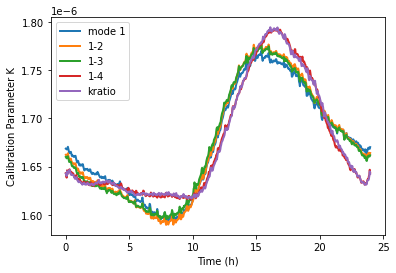

In [314]:
i = 30
plt.plot(lst_2min, mode1[:, i], lw = 2, label='mode 1')
plt.plot(lst_2min, mode1[:, i] + mode2[:, 30], lw = 2, label='1-2')
plt.plot(lst_2min, mode1[:, i] + mode2[:, 30] + mode3[:,30], lw = 2, label='1-3')
plt.plot(lst_2min, mode1[:, i] + mode2[:, 30] + mode3[:,30] + mode4[:,30], lw = 2, label='1-4')
plt.plot(lst_2min, krat[:, i], lw = 2, label='kratio')
#plt.plot(mode1[:,10],lw = 2, ls = ":")
#plt.plot(mode1[:,20],lw = 2, ls = ":")
plt.xlabel('Time (h)')
plt.ylabel('Calibration Parameter K')
plt.legend()

## Fit

T_sky computed at this 

In [240]:
# Set the random seed.
np.random.seed(0)

def Tcd(a1, nu_0, w):
    return - a1 * np.exp(-1/2 * (x - nu_0)**2 / w**2)

def model(params, v_0):
    deg = len(params)
    return np.sum([params[i]*(np.log10(x/v_0))**(i) for i in range(deg)], axis=0)
    
# Define log-likelihood
def log_likelihood(params, v_0, data):
    Tcmb = 2.725
    a1, nu_0, w = params[-4:-1]
    m = 10**model(params[:-4], v_0) + Tcmb + Tcd(a1, nu_0, w)
    sigma = params[-1]
    return -1.2 * np.sum(((data - m) / sigma)**2 + np.log(2 * np.pi * sigma **2))

ndim = 4
# Define uniform prior: k1 [1e-2, 1e2], k2 [-1e5,1e5]
prior = pc.Prior(ndim * [stats.uniform(loc=-50, scale=100)] + \
                 [stats.uniform(loc=0, scale=1)] + [stats.uniform(loc=50, scale=150)] + [stats.uniform(loc=10, scale=20)] + \
                 [stats.loguniform(1e-4, 1e1)]) 

In [257]:
observed = (mode1+mode2+mode3+mode4) * data_binned[:,::2]
obs=np.nanmean(observed, axis=0)
# mask = np.isnan(data)
# data[mask] = 0

# Initialise sampler
sampler = pc.Sampler(
    prior=prior,
    likelihood=log_likelihood,
    likelihood_args=[100, obs],
    random_state=0
)

In [258]:
sampler.run()

Iter: 76it [07:05,  5.60s/it, beta=1, calls=482560, ESS=3944, logZ=-368, logP=-347, acc=0.198, steps=40, eff=0.0172]          


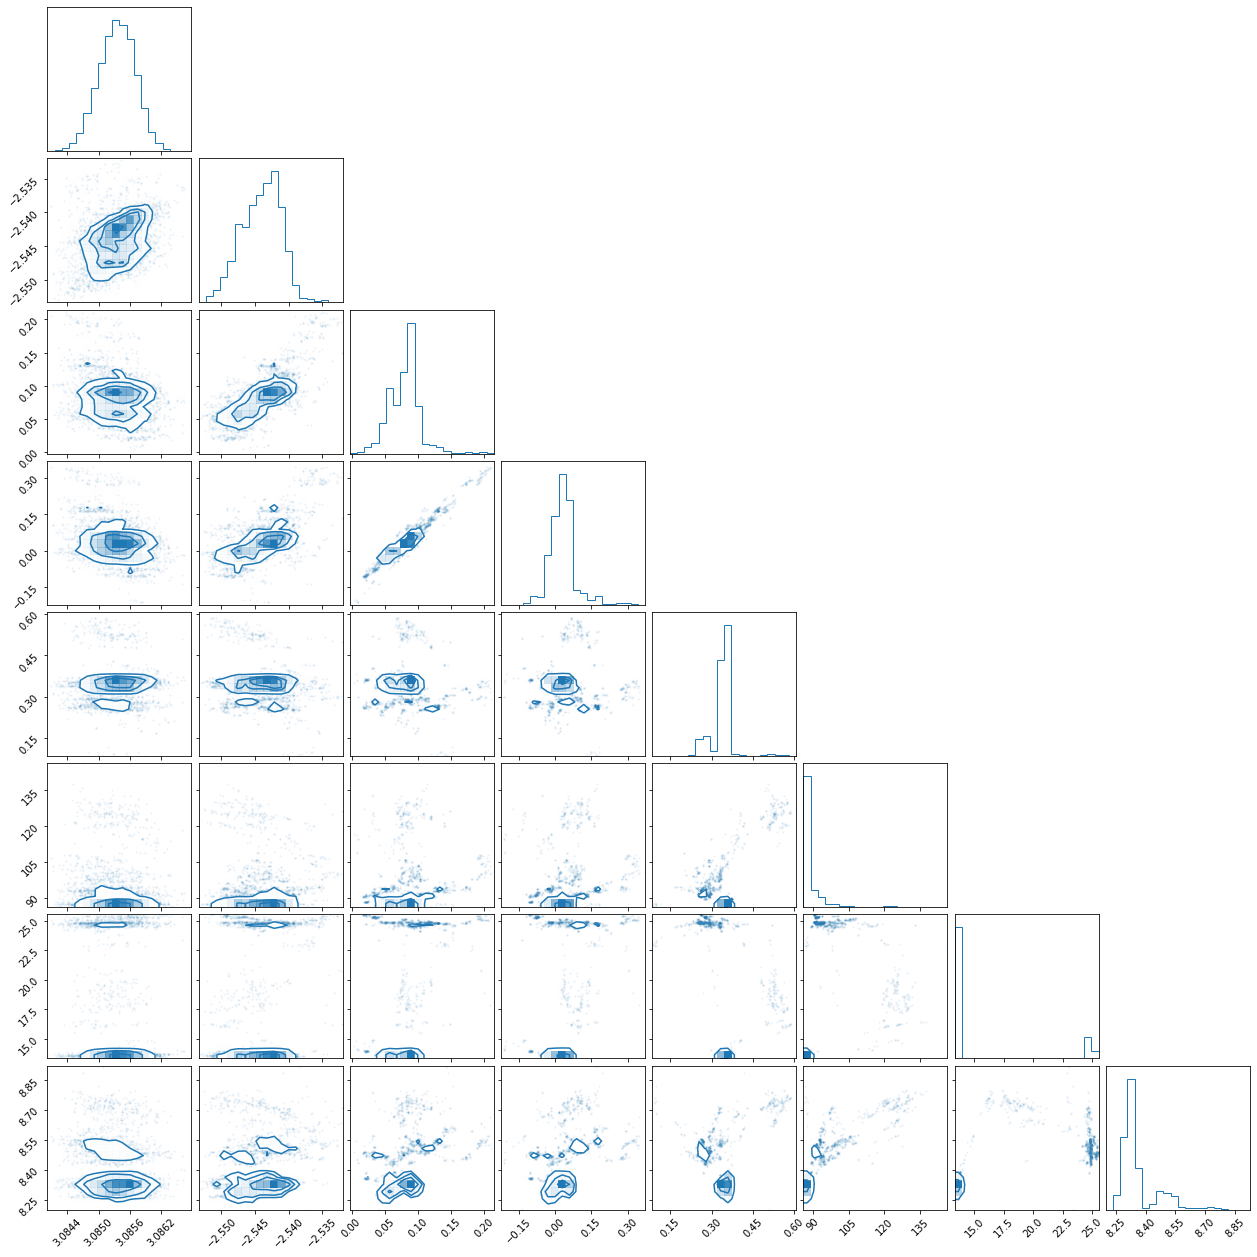

In [259]:
# Get the results
samples, weights, logl, logp = sampler.posterior()

# Trace plot
fig = corner.corner(samples, weights=weights, color="C0")
plt.show()

array([ 3.08572355e+00, -2.54098017e+00,  8.61961005e-02,  1.55784339e-02,
        3.34563867e-01,  9.83589693e+01,  2.47281075e+01,  8.68886198e+00])

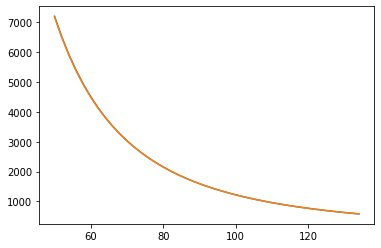

In [260]:
best_params = mode(samples, axis=0)[0][0]
plt.plot(x, obs)
plt.plot(x, 10**model(best_params[:-4], 100) + Tcmb + Tcd(best_params[-4], best_params[-3], best_params[-2]))
samples[i]

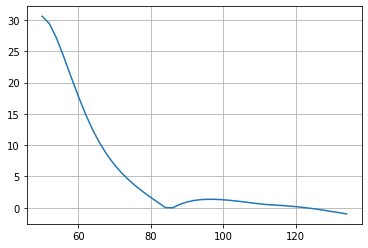

In [261]:
plt.grid()
plt.plot(x, obs - (10**model(best_params[:-4], 100) + Tcmb + Tcd(best_params[-4], best_params[-3], best_params[-2])))

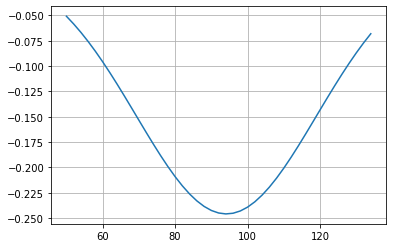

In [262]:
plt.grid()
plt.plot(x, Tcd(best_params[-4], best_params[-3], best_params[-2]))

In [263]:
# Get the evidence and its uncertainty
logz, logz_err = sampler.evidence()

print("logZ", round(logz), "+-", round(logz_err))

logZ -389 +- 15


### polyfit

In [227]:
observed = (mode1) * data_binned[:,::2]
obs=np.nanmean(observed, axis=0)
# obs = observed[500]
v_0 = 100 # MHz

poly=3
fit = np.polyfit(np.log10(x/v_0), np.log10(obs), poly)    
power = np.zeros(len(x))
i = 0
while i <= poly:
    power = power + fit[poly-i]*(np.log10(x/v_0))**i
    i += 1
y_3 = 10**(power)

poly=6
fit = np.polyfit(np.log10(x/v_0), np.log10(obs), poly)    
power = np.zeros(len(x))
i = 0
while i <= poly:
    power = power + fit[poly-i]*(np.log10(x/v_0))**i
    i += 1
y_6 = 10**(power)

In [228]:
fit

array([12.39488036,  8.2291249 ,  0.25402174, -0.46878931,  0.04402728,
       -2.53489431,  3.08651709])

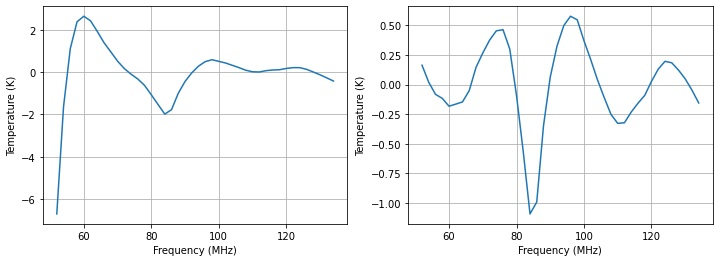

In [229]:
fig = plt.figure(figsize=(12,4))
ax = fig.subplots(1,2)

ax[0].grid()
# ax[0].set_ylim(-10,10)
ax[0].plot(x, obs - y_3)
ax[0].set_ylabel('Temperature (K)')
ax[0].set_xlabel('Frequency (MHz)')

ax[1].grid()
# ax[1].set_ylim(-2,2)
ax[1].plot(x, obs - y_6)
ax[1].set_ylabel('Temperature (K)')
ax[1].set_xlabel('Frequency (MHz)')
plt.show()

### Individual days

In [22]:
days = hf.split_days(lst)

In [266]:
modes = []
binned_data_1day = []
for i in range(len(days)-1):
    data_binned_day, _, _, _, _ = hf.binning(data[days[i]:days[i+1]], freq, lst[days[i]:days[i+1]], binsize_f, binsize_t, flow, fhigh)
    
    #get first 5 modes of K
    mode1= np.reshape(U[:,0],(krat.shape[0],1))*sigma[0,0]* np.reshape(VH[0,:], (1,krat.shape[1]))
    mode2= np.reshape(U[:,1],(krat.shape[0],1))*sigma[1,1]* np.reshape(VH[1,:], (1,krat.shape[1]))
    mode3= np.reshape(U[:,2],(krat.shape[0],1))*sigma[2,2]* np.reshape(VH[2,:], (1,krat.shape[1]))
    mode4= np.reshape(U[:,3],(krat.shape[0],1))*sigma[3,3]* np.reshape(VH[3,:], (1,krat.shape[1]))
    mode5= np.reshape(U[:,4],(krat.shape[0],1))*sigma[4,4]* np.reshape(VH[4,:], (1,krat.shape[1]))
    
    modes.append([mode1, mode2, mode3, mode4, mode5])
    binned_data_1day.append(data_binned_day)

/gpfs/fs0/scratch/s/sievers/nasuyu/PRIZM/prizm-analysis/helper_functions.py:63: RuntimeWarning: Mean of empty slice
  data_binned = np.array([[np.nanmean(data[bin_inds_t == i][:, bin_inds_f == j]) \


### pocomc

In [345]:
# Set the random seed.
np.random.seed(0)

def model(params, v_0):
    deg = len(params)
    return np.sum([params[i]*(np.log10(x/v_0))**(i) for i in range(deg)], axis=0)
    
# Define log-likelihood
def log_likelihood(params, v_0, data):
    m = model(params, v_0) 
    return -1/2 * np.sum((data - m)**2)

ndim = 4
# Define uniform prior: k1 [1e-2, 1e2], k2 [-1e5,1e5]
prior = pc.Prior(ndim * [stats.uniform(loc=-10, scale=20)]) 

In [364]:
# Set the random seed.
np.random.seed(0)

def Tcd(a1, nu_0, w):
    return - a1 * np.exp(-1/2 * (x - nu_0)**2 / w**2)

def model(params, v_0):
    deg = len(params)
    return np.sum([params[i]*(np.log10(x/v_0))**(i) for i in range(deg)], axis=0)
    
# Define log-likelihood
def log_likelihood(params, v_0, data):
    Tcmb = 2.725
    a1, nu_0, w = params[-4:-1]
    m = 10**model(params[:-4], v_0) + Tcmb + Tcd(a1, nu_0, w)
    sigma = params[-1]
    return -1/2 * np.sum(((data - m) / sigma)**2 + np.log(2 * np.pi * sigma **2))

ndim = 4
# Define uniform prior: k1 [1e-2, 1e2], k2 [-1e5,1e5]
prior = pc.Prior(ndim * [stats.uniform(loc=-10, scale=20)] + \
                 [stats.uniform(loc=0, scale=0.25)] + [stats.uniform(loc=50, scale=150)] + [stats.uniform(loc=10, scale=10)] + \
                 [stats.loguniform(1e-4, 1e1)]) 

In [365]:
d = 2
num_modes = 2

observed = np.sum(modes[d][:num_modes], axis=0) * binned_data_1day[d][:,::2]
obs=np.nanmean(observed, axis=0)
# mask = np.isnan(data)
# data[mask] = 0

# Initialise sampler
sampler = pc.Sampler(
    prior=prior,
    likelihood=log_likelihood,
    likelihood_args=[100, obs],
    random_state=0
)

In [366]:
sampler.run()

Iter: 62it [04:22,  4.23s/it, beta=1, calls=248064, ESS=3879, logZ=-169, logP=-159, acc=0.216, steps=40, eff=0.288]      


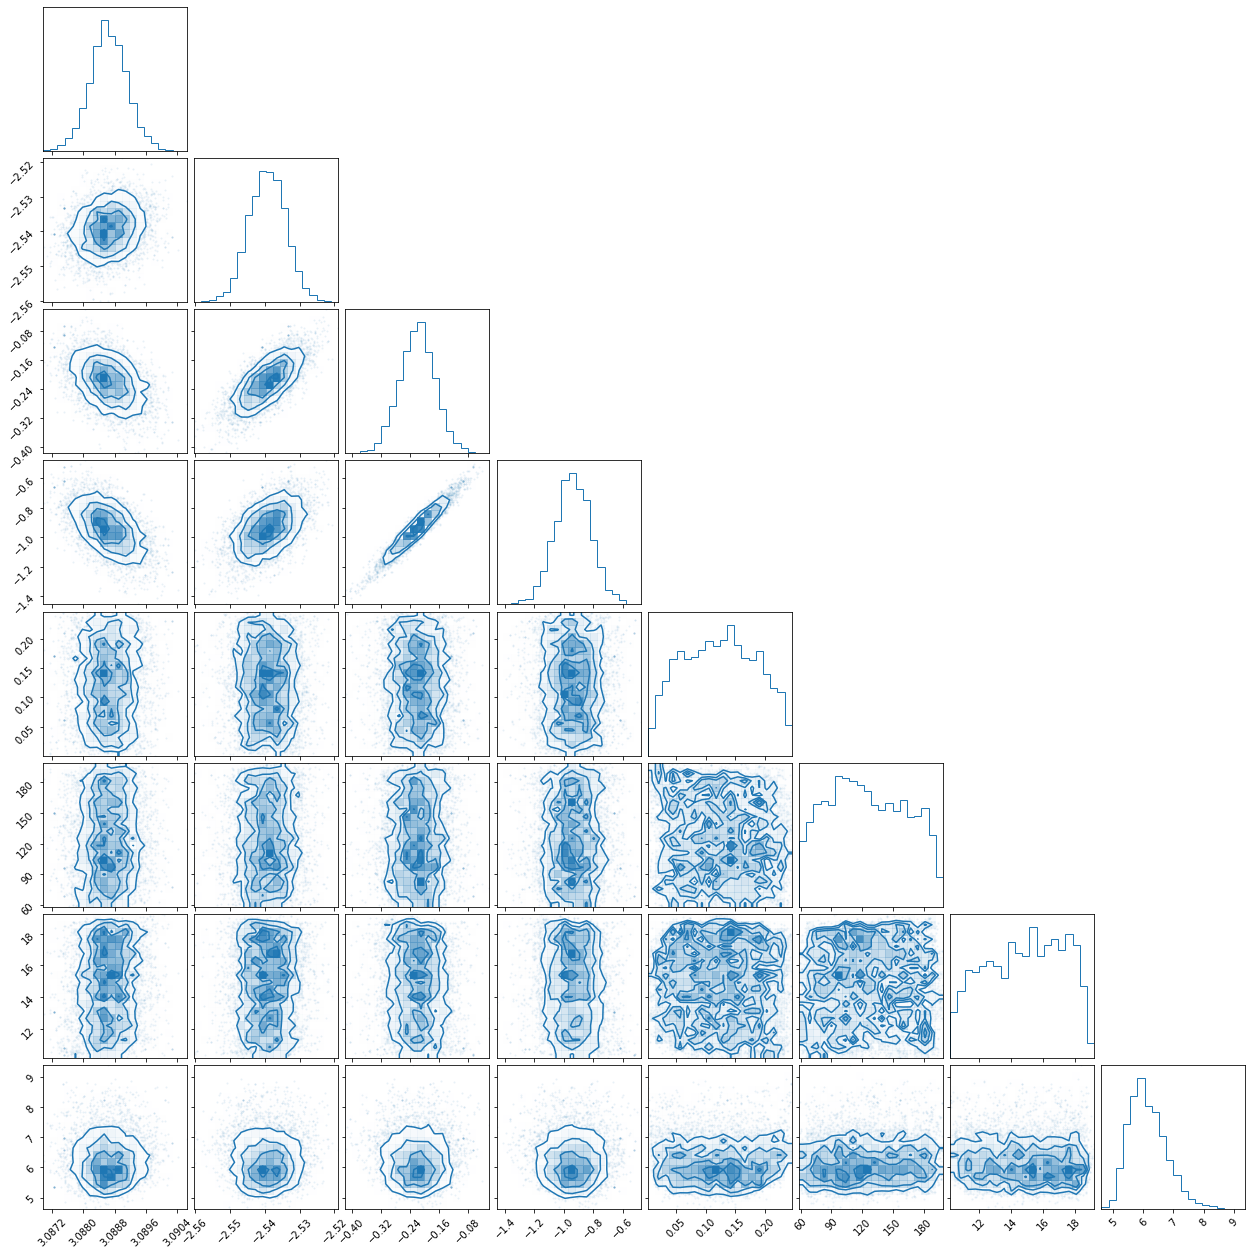

In [367]:
# Get the results
samples, weights, logl, logp = sampler.posterior()

# Trace plot
fig = corner.corner(samples, weights=weights, color="C0")
plt.show()

[ 3.08725996e+00 -2.54078920e+00 -1.25920906e-01 -6.56868283e-01
  1.70739179e-01  1.49795488e+02  1.30349802e+01  5.35684271e+00]


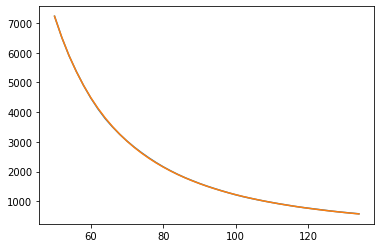

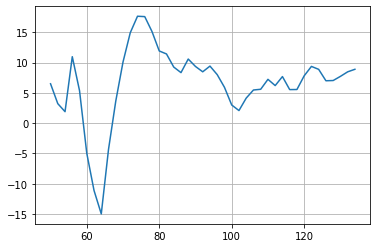

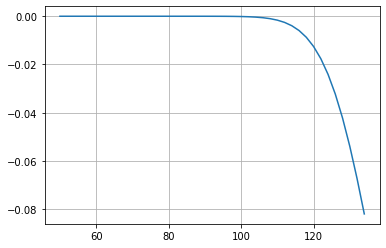

In [368]:
best_params = mode(samples, axis=0)[0][0]
print(best_params)
plt.plot(x, obs)
plt.plot(x, 10**model(best_params[:-4], 100) + Tcmb + Tcd(best_params[-4], best_params[-3], best_params[-2]))
plt.show()

plt.grid()
plt.plot(x, obs - 10**model(best_params[:-4], 100) + Tcmb + Tcd(best_params[-4], best_params[-3], best_params[-2]))
plt.show()

plt.grid()
plt.plot(x, Tcd(best_params[-4], best_params[-3], best_params[-2]))

In [369]:
# Get the evidence and its uncertainty
logz, logz_err = sampler.evidence()

print("logZ", round(logz), "+-", round(logz_err))

logZ -168 +- 1


### polyfit

In [342]:
fits = []
y6_1day = []
obs_1day = []
num_modes = 2

for i in range(len(days)-1): 
    observed = np.nansum(modes[i][:num_modes], axis=0) * binned_data_1day[i][:,::2]
    obs=np.nanmean(observed, axis=0)
    # obs = observed[500]

    poly=3
    fits.append(np.polyfit(np.log10(x/100), np.log10(obs), poly))
    power = np.zeros(len(x))
    i = 0
    while i <= poly:
        power = power + fits[-1][poly-i]*(np.log10(x/100))**i
        i += 1
    y6_1day.append(10**(power))
    obs_1day.append(obs)

/tmp/ipykernel_125873/3597720609.py:8: RuntimeWarning: Mean of empty slice
  obs=np.nanmean(observed, axis=0)


In [343]:
fits

[array([-0.86838283,  0.17096182, -2.4772951 ,  3.17777986]),
 array([ 0.56543761,  0.11517615, -2.56579457,  3.10085696]),
 array([-0.48321114, -0.07016663, -2.53204388,  3.08875975]),
 array([-0.11515538,  0.00709004, -2.54053009,  3.0870491 ]),
 array([ 0.0090176 , -0.02749049, -2.58857215,  2.90317375]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([ 0.42124478,  0.20216777, -2.56423212,  3.08531344]),
 array([ 0.61437438,  0.20567729, -2.55640302,  3.08804933]),
 array([ 0.51927281,  0.2110677 , -2.58272663,  3.04742253]),
 array([ 0.47893732,  0.15440566, -2.55335731,  3.08701006]),
 array([ 0.58004216,  0.21003441, -2.54942837,  3.08600936]),
 array([-0.38979888, -0.11548294, -2.56191638,  3.04348507]),
 array([-0.40806624, -0.05006467, -2.54500829,  3.086856  ]),
 array([-1.29946346, -0.12242116, -2.48128345,  3.12139718]),
 array([-0.52345827, -0.05289892, -2.51448306,  3.0887403 ]),
 array([-1.40778231, -0.36109861, -2.55699

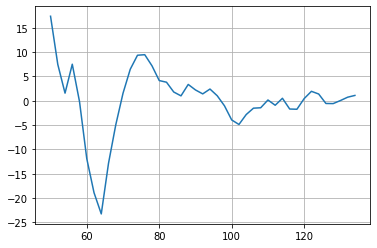

In [360]:
plt.grid()
plt.plot(x, obs_1day[d] - y6_1day[d])

Text(0.5, 0, 'Frequency (MHz)')

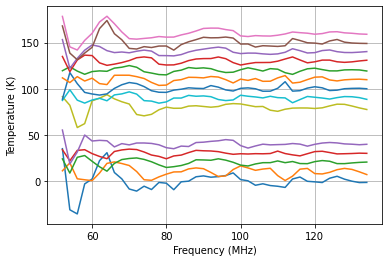

In [51]:
fig = plt.figure()
ax = fig.subplots(1,1)
ax.grid()
# ax.set_ylim(-10,100)
# for i in range(1,14):
for i in range(len(y6_1day) - 1):
    ax.plot(x, 10*i + obs_1day[i] - y6_1day[i])
ax.set_ylabel('Temperature (K)')
ax.set_xlabel('Frequency (MHz)')

Text(0.5, 0, 'Frequency (MHz)')

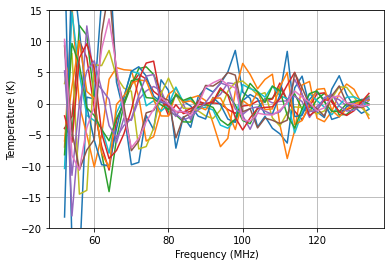

In [30]:
fig = plt.figure()
ax = fig.subplots(1,1)
ax.grid()
ax.set_ylim(-20,15)
for i in range(len(y6_1day) - 1):
    ax.plot(x, obs_1day[i] - y6_1day[i])
ax.set_ylabel('Temperature (K)')
ax.set_xlabel('Frequency (MHz)')